In [93]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.io import read_image
from tqdm import tqdm

import pandas as pd
import os
from PIL import Image

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as cm

In [94]:
device = ("cuda:0" if torch.cuda.is_available() else "cpu")

device

'cpu'

In [95]:
cap = cv2.VideoCapture('../data/test_set/test_set/test_23.jpg')
cap2 = cv2.imread("../data/test_set/test_set/test_23.jpg")
fgbg = cv2.createBackgroundSubtractorMOG2()
ret, frame = cap.read()
 
fgmask = fgbg.apply(frame)
fgmask = np.repeat(fgmask[:, :, np.newaxis], 3, axis=2)

img = cap2 - fgmask

cv2.imshow('fgmask', fgmask)
cv2.imshow('frame',frame )
cv2.imshow("Image", img)

k = cv2.waitKey(0)

cap.release()
cv2.destroyAllWindows()

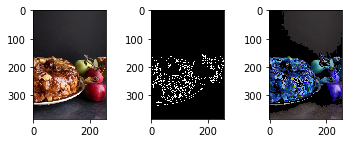

In [96]:
# Read the image
img = cv2.imread("../data/test_set/test_set/test_1.jpg")

# Apply thresholds for the bound selection
threshold1,threshold2 = 50, 700
grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
image = cv2.Canny(img, threshold1, threshold2)

# Convert images to correct sizes
image_new = np.repeat(image[:, :, np.newaxis], 3, axis=2)
grey_new = np.repeat(grey[:, :, np.newaxis], 3, axis=2)

# Applying grey scale and applying the bounds --> These need to be optimized.
new_image = img * image_new + (1 - grey_new)
new_image = img * ((new_image > 50) * (new_image < 220))

#selecting the color range to be extracted
fig = plt.figure(figsize=(6, 2))
axarr = fig.subplots(1, 3)

axarr[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axarr[1].imshow(image, cmap='gray')
axarr[2].imshow(new_image)

plt.show()

In [191]:
class food_train(Dataset):

    def __init__(self, labels_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(labels_file, names=['img_name', 'label'], header=1)[:25000]
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        img = read_image(img_path).numpy().T

        # Apply thresholds for the bound selection
        threshold1,threshold2 = 50, 700
        grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        image = cv2.Canny(img, threshold1, threshold2)

        # Convert images to correct sizes
        image_new = np.repeat(image[:, :, np.newaxis], 3, axis=2)
        grey_new = np.repeat(grey[:, :, np.newaxis], 3, axis=2)

        # Applying grey scale and applying the bounds --> These need to be optimized.
        new_image = img * image_new + (1 - grey_new)
        new_image = img * ((new_image > 50) * (new_image < 220))
        
        label = self.img_labels.iloc[idx, 1]
        new_image = torch.from_numpy(new_image).T
        
        if self.transform:
            image = self.transform(new_image)
            
        return image, label
    

In [192]:
class food_val(Dataset):

    def __init__(self, labels_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(labels_file, names=['img_name', 'label'], header=1)[25000:]
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        img = read_image(img_path).numpy().T

        # Apply thresholds for the bound selection
        threshold1,threshold2 = 50, 700
        grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        image = cv2.Canny(img, threshold1, threshold2)

        # Convert images to correct sizes
        image_new = np.repeat(image[:, :, np.newaxis], 3, axis=2)
        grey_new = np.repeat(grey[:, :, np.newaxis], 3, axis=2)

        # Applying grey scale and applying the bounds --> These need to be optimized.
        new_image = img * image_new + (1 - grey_new)
        new_image = img * ((new_image > 50) * (new_image < 220))
        
        label = self.img_labels.iloc[idx, 1]
        new_image = torch.from_numpy(new_image).T
        
        if self.transform:
            image = self.transform(new_image)
            
        return image, label
    



In [193]:
class food_test(Dataset):

    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        file_name = os.listdir(self.img_dir)[idx]
        img_path = os.path.join(self.img_dir, file_name)
        img = read_image(img_path).numpy().T

        # Apply thresholds for the bound selection
        threshold1,threshold2 = 50, 700
        grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        image = cv2.Canny(img, threshold1, threshold2)

        # Convert images to correct sizes
        image_new = np.repeat(image[:, :, np.newaxis], 3, axis=2)
        grey_new = np.repeat(grey[:, :, np.newaxis], 3, axis=2)

        # Applying grey scale and applying the bounds --> These need to be optimized.
        new_image = img * image_new + (1 - grey_new)
        new_image = img * ((new_image > 50) * (new_image < 220))
        
        label = self.img_labels.iloc[idx, 1]
        new_image = torch.from_numpy(new_image).T
        
        if self.transform:
            image = self.transform(new_image)
        
        return file_name, image

In [194]:
img_dir = "../data/train_set/train_set"
labels = "../data/train_labels.csv"


transform = transforms.Compose(
                    [transforms.Resize((256,256)),
                     transforms.ConvertImageDtype(torch.float),
                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225])])


train_set = food_train(labels, img_dir, transform = transform)  
trainloader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=0)

val_set = food_val(labels, img_dir, transform = transform)
valloader = DataLoader(val_set, batch_size=32, shuffle=True, num_workers=0)


len(train_set), len(val_set)

(25000, 5611)

In [195]:
test_set = food_test("../data/test_set/test_set", transform = transform)
testloader = DataLoader(test_set, batch_size = 32, shuffle=True, num_workers=0)

len(test_set)

7653

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


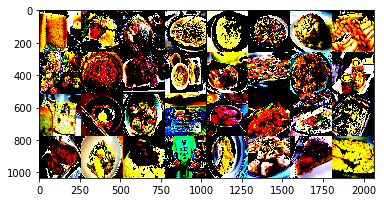

tensor(57) tensor(64) tensor(58) tensor(50) tensor(77) tensor(4) tensor(29) tensor(25)


In [196]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()


batch_size = 8

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j] for j in range(batch_size)))

In [197]:
torch.cuda.get_device_name(0)

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [198]:
resnet = models.resnet18(pretrained=True)
resnet.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Matthijs Zwemmer/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [199]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

In [200]:
def train_loop(dataloader, model, criterion, optimizer):
    size = len(dataloader.dataset)
    
    model.train()
    for epoch in range(15):
        for batch, (image, label) in enumerate(dataloader):
            # Compute prediction and loss
            image, label = image.to(device), label.to(device)
            pred = model(image)
            loss = criterion(pred, label)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch % 200 == 0:
                loss, current = loss.item(), batch * len(image)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}] epoch: {epoch}")
                
        print(f"Epoch: {epoch}")
        test_loop(valloader, resnet, criterion)


def test_loop(dataloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for image, label in dataloader:
            image, label = image.to(device), label.to(device)
            pred = model(image)
            test_loss += criterion(pred, label).item()
            correct += (pred.argmax(1) == label).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [201]:
train_loop(trainloader, resnet, criterion, optimizer)

loss: 9.124754  [    0/25000] epoch: 0


KeyboardInterrupt: 